In [1]:
import matplotlib.pyplot as plt
from matplotlib import colors
import six

import numpy as np
from matplotlib.dates import num2date,date2num

import xarray as xr
import pandas as pd
import os

from stompy import utils
from stompy.grid import unstructured_grid, multi_ugrid
import stompy.model.data_comparison as dc

import stompy.model.delft.dflow_model as dfm
import pesca_base
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

DFM_ROOT NOT SET
local_config: LD_LIBRARY_PATH:
/share/apps/mpfr-3.1.2/lib:/share/apps/openmpi-4.0.1/gcc7/lib:/share/apps/slurm-21.08.8-2/18.04/lib
------------


In [2]:
%matplotlib notebook

In [3]:
# Load the ESA dataset:
esa_waterlevel=xr.open_dataset("../calibration/esa_compiled_waterlevel.nc")

In [4]:
# Load BML dataset:
bml_data_dir="../../data/BML data/2016/all_concatenated"

# BC1 starts later.  All other sites okay for this period.

# Shift to NAVD88 adjusted data:
fn=os.path.join(bml_data_dir,
                '../water_level/elevationNAVD88',
                '2016_NCK_wll_referenced_concat.csv')
df=pd.read_csv(fn)
# UTC
df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
df['depth m']=df['NAVD88']
nck_wll=df.set_index('time')
nck_wll.head()

INFO:numexpr.utils:Note: NumExpr detected 24 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,year,month,day,hour,minute,second,temp degC,depth m,NAVD88
time,,,,,,,,,
2016-04-06 23:24:00,2016,4,6,23,24,0,13.846,1.258192,1.258192
2016-04-06 23:27:00,2016,4,6,23,27,0,13.269,1.257183,1.257183
2016-04-06 23:30:00,2016,4,6,23,30,0,12.980,1.255166,1.255166
2016-04-06 23:33:00,2016,4,6,23,33,0,12.883,1.253148,1.253148
2016-04-06 23:36:00,2016,4,6,23,36,0,12.787,1.249114,1.249114


In [5]:
# Load QCM data, too -- code taken from pesca_base.py
qcm_pre2016=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output.csv",                                                                     
                        skiprows=[0],usecols=range(7),                                                                                              
                        parse_dates=['Date (PST)'])                                                                                                 
qcm_2016_2017=pd.read_csv("../../data/ESA_QCM/ESA_draft_PescaderoQCM_output_4.28.2021.csv",                                                         
                          skiprows=[0],usecols=range(14),                                                                                           
                          parse_dates=['Date (PST)'])                                                                                               
# some extra rows in the csv                                                                                                                        
qcm_2016_2017=qcm_2016_2017[ ~qcm_2016_2017['Date (PST)'].isnull() ]                                                                                
qcm=pd.concat([qcm_pre2016,qcm_2016_2017],sort=False)                                                                                                          

qcm['time']=qcm['Date (PST)'] + np.timedelta64(8,'h') # Shift to UTC.                                                        
# These are both NAVD88, converted ft=>m                                                                                                            
# Prefer the modified data when available:                                                                                                          
ocean_modified=qcm['Modified Ocean Level (feet NAVD88)']                                                                                            
# Otherwise the observed data.                                                                                                                      
ocean_level=qcm['Ocean level (feet NAVD88)']                                                                                                        
qcm['z_ocean']=0.3048 * ocean_modified.combine_first(ocean_level)
qcm['z_ocean_orig']=0.3048 * ocean_level

qcm['z_thalweg']=0.3048 * qcm['Modeled Inlet thalweg elevation (feet NAVD88)']                                                                      
# width                                                                                                                                             
qcm['w_inlet']=0.3048* qcm['Modeled Inlet Width (feet)'] 
qcm['seepage']=qcm['Modeled seepage'] * 0.3048**3

qcm_ds=xr.Dataset.from_dataframe(qcm[ ['time','z_ocean',
                                       'z_ocean_orig','z_thalweg','w_inlet',
                                       'seepage']
                                    ].set_index('time'))                

In [6]:
# Updated test, using BML data
observed=xr.Dataset.from_dataframe(nck_wll)['depth m'].assign_coords(label='NCK wll')

In [11]:
models=[ 
    #pesca_base.PescaButano.load('data_salt_filling-v04_existing_impaired'),
    #pesca_base.PescaButano.load('data_salt_filling-v04_existing_unimpaired'),
    #pesca_base.PescaButano.load('data_salt_filling-v04_asbuilt_impaired'), 
    pesca_base.PescaButano.load('data_salt_filling-v05_existing_impaired'), 
    #pesca_base.PescaButano.load('data_salt_filling-v04_asbuilt_unimpaired')   
    #pesca_base.PescaButano.load('data-2016-3d-asbuilt-impaired-v06'),
    #pesca_base.PescaButano.load('data_2016_3d_asbuilt_impaired-v001'),
    #pesca_base.PescaButano.load('data_2016_2d_asbuilt_impaired_scen1'),
    #pesca_base.PescaButano.load('data_2016long_2d_asbuilt_impaired_scen2'),
    #pesca_base.PescaButano.load('data_2016_2d_asbuilt_impaired_scen3-v001'),
    #pesca_base.PescaButano.load('data_2016_2d_asbuilt_impaired'),
    # pesca_base.PescaButano.load('data_2013_3d_asbuilt_impaired_slr0.61m-v001'),
    #pesca_base.PescaButano.load('data_2016long_3d_asbuilt_impaired-v015'), # 100 layers
    #pesca_base.PescaButano.load('data_2016long_3d_asbuilt_impaired-v016'), # 30 layers
    #pesca_base.PescaButano.load('data_2016long_3d_asbuilt_impaired-v017'), # 30 layers
    #pesca_base.PescaButano.load('data_2016long_3d_asbuilt_impaired-v018'), # 30 layers
    #pesca_base.PescaButano.load('data_2016long_3d_asbuilt_impaired-v019'), # 30 layers
    #pesca_base.PescaButano.load('data_2016long_3d_asbuilt_impaired_scen1'), # 30 layers    
    pesca_base.PescaButano.load('data_2016long_3d_asbuilt_impaired-v020'), # 100 layers    
    pesca_base.PescaButano.load('data_2016long_3d_asbuilt_impaired-v020_r01'), # 100 layers   
    pesca_base.PescaButano.load('data_2016long_3d_asbuilt_impaired_scen0_l100-v025'), # 100 layers   
    pesca_base.PescaButano.load('data_2016long_3d_asbuilt_impaired_scen0_l100-v026'), # 100 layers   
    
       ]
model0=models[0]

INFO:HydroModel:New grid with bathy needed? False
INFO:HydroModel:New fixed weirs needed? False


Range of QCM data: 2006-01-01T08:00:00.000000000 to 2018-01-01T08:00:00.000000000


INFO:HydroModel:Resampling leads to 75 points for thalweg_pesc
INFO:HydroModel:Resampling leads to 52 points for thalweg_butano
INFO:HydroModel:Bottom interface moved from -0.250 to -0.435 to match deepest node of grid


Setting seepage


INFO:HydroModel:New grid with bathy needed? False
INFO:HydroModel:New fixed weirs needed? False


Range of QCM data: 2006-01-01T08:00:00.000000000 to 2018-01-01T08:00:00.000000000
Setting seepage


INFO:HydroModel:Resampling leads to 75 points for thalweg_pesc
INFO:HydroModel:Resampling leads to 52 points for thalweg_butano
INFO:HydroModel:Bottom interface moved from -0.250 to -0.435 to match deepest node of grid
INFO:HydroModel:New grid with bathy needed? False
INFO:HydroModel:New fixed weirs needed? False


Range of QCM data: 2006-01-01T08:00:00.000000000 to 2018-01-01T08:00:00.000000000


INFO:HydroModel:Resampling leads to 75 points for thalweg_pesc
INFO:HydroModel:Resampling leads to 52 points for thalweg_butano
INFO:HydroModel:Bottom interface moved from -0.250 to -0.435 to match deepest node of grid


Setting seepage


INFO:HydroModel:New grid with bathy needed? False
INFO:HydroModel:New fixed weirs needed? False


Range of QCM data: 2006-01-01T08:00:00.000000000 to 2018-01-01T08:00:00.000000000


INFO:HydroModel:Resampling leads to 75 points for thalweg_pesc
INFO:HydroModel:Resampling leads to 52 points for thalweg_butano
INFO:HydroModel:Bottom interface moved from -0.250 to -0.435 to match deepest node of grid


Setting seepage


INFO:HydroModel:New grid with bathy needed? False
INFO:HydroModel:New fixed weirs needed? False


Range of QCM data: 2006-01-01T08:00:00.000000000 to 2018-01-01T08:00:00.000000000
Setting seepage


INFO:HydroModel:Resampling leads to 75 points for thalweg_pesc
INFO:HydroModel:Resampling leads to 52 points for thalweg_butano
INFO:HydroModel:Bottom interface moved from -0.250 to -0.435 to match deepest node of grid


In [8]:
bcs=model0.load_bcs()
ocean_bc=[bc for bc in bcs if bc['name']=='ocean_bc'][0]

Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=salinitybnd
Not implemented: reading BC quantity=discharge_salinity_temperature_sorsin
Not implemented: reading BC quantity=discharge_salinity_temperature_sorsin
Not implemented: reading BC quantity=rainfall_rate
Not implemented: reading BC quantity=windxy


In [9]:
mu=models[-1].map_dataset()

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)
INFO:UnstructuredGrid:max_sides is okay (4)


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


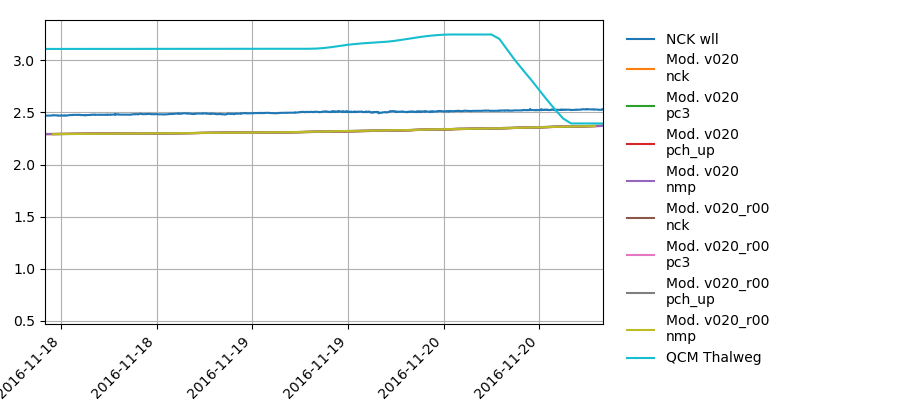

(17122.958333333332, 17125.875, 0.4671969712176, 3.3887030924304002)

In [12]:
import six
six.moves.reload_module(dc)

sources=[observed]

model_labels=['Mod. %s'%ds 
              for ds in utils.distinct_substrings([mod.run_dir for mod in models])]        
    
for model,label in zip(models,model_labels): 
    his_ds=model.his_dataset()

    for model_stn in ['nck','pc3','pch_up','nmp']:
        predicted=his_ds['waterlevel'].sel(stations=model_stn)
        predicted=predicted.assign_coords(label=f'{label}\n{model_stn}'.replace('data_',''))
        sources.append(predicted)
    
    his_ds.close()

# sources.append( ocean_bc['data']['stage'].isel(node=0).assign_coords(label='BC'))

fig=dc.calibration_figure_3panel(sources,trim_time=False,lowpass=False,metric_x=None,
                                 offset_source=None)
fig.axes[2].set_visible(0)
fig.axes[1].set_visible(0)

ax=fig.axes[0]

plt.setp(ax.get_xticklabels(),rotation=45,ha='right')
ax.grid(1)

if 1: # Add in QCM time series
    #ax.plot(qcm.time,qcm.z_ocean,label='QCM Ocean (adj)')
    #ax.plot(qcm.time,qcm.z_ocean_orig,label='QCM Ocean (orig)')
    #ax.plot(qcm.time,qcm['Modeled Lagoon Level (feet NAVD88)']*0.3048,
    #        label='QCM Model Lagoon')
    ax.plot(qcm.time,qcm['z_thalweg'],label='QCM Thalweg')
    #ax.plot(qcm.time,qcm['w_inlet'],label='QCM Width')
    

fig.set_size_inches([9,4],forward=True)
ax.legend(loc='upper left',bbox_to_anchor=[1.02,1], frameon=0)
ax.set_position([0.05,0.19,0.62,0.76])

ax.axis( xmin=his_ds.time.values[0]-np.timedelta64(1,'h'),
         xmax=his_ds.time.values[-1]+np.timedelta64(1,'h'))


#ax.axis((16969.044347661897, 16969.801914782973, 0.21143524775386066, 2.0655442341305115))
#ax.plot(mu.time.values,np.ones(len(mu.time.values)),
#        'ro',label='Map output')
#ax.axvline(mu.time.values[34],color='r')

In [46]:
plt.close('all')

<IPython.core.display.Javascript object>


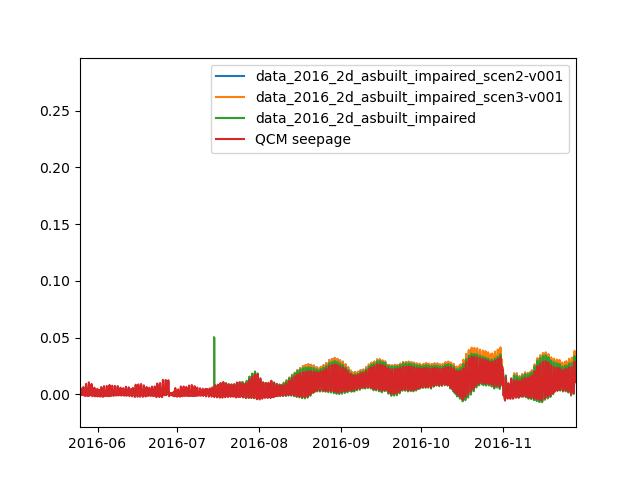

data_2016_2d_asbuilt_impaired_scen2-v001
node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist
data_2016_2d_asbuilt_impaired_scen3-v001
Some lines are degenerate
data_2016_2d_asbuilt_impaired
node_coordinates cross_section_geom_node_coordx cross_section_geom_node_coordy do not exist


In [37]:
# Compare seepage
fig,ax=plt.subplots()

for mod in models:
    print(mod.run_dir)
    his_ds=mod.his_dataset()
    ax.plot(his_ds.time,
            his_ds.source_sink_current_discharge.sel(source_sink='seepage'),
            label=mod.run_dir)
    
ax.plot(qcm_ds.time,-qcm_ds.seepage,label='QCM seepage')
ax.legend()


Salinity Comparisons
--

In [9]:
def load_bml(fname):
    df=pd.read_csv("../../data/BML data/2016/all_concatenated/csv/"+fname)
    # UTC
    df['time']=pd.to_datetime( df[ ['year','month','day','hour','minute','second']])
    # some stations have some bad, -99 values
    df.loc[df.salinity<0,'salinity']=np.nan
    missing=df.time.isnull()
    df=df[~missing]
    df.set_index('time',inplace=True)
    return df

bml_nck_sfc_mcat=load_bml("NCK_sfc_mcat_concatenated.csv")
bml_nck_btm_mcat=load_bml("NCK_btm_mcat_concatenated.csv")
bml_pc3_sfc_sond=load_bml("PC3_sfc_sonde_concatenated.csv")
bml_pc3_btm_sond=load_bml("PC3_btm_sonde_concatenated.csv")

bml_bc1_btm_sond=load_bml("BC1_btm_sonde_concatenated.csv")
bml_bc1_sfc_sond=load_bml("BC1_sfc_sonde_concatenated.csv")

bml_bc3_btm_mcat=load_bml("BC3_btm_mcat_concatenated.csv")
bml_bc3_sfc_mcat=load_bml("BC3_sfc_mcat_concatenated.csv")

bml_ch2_btm_mcat=load_bml("CH2_btm_mcat_concatenated.csv")
bml_ch2_sfc_mcat=load_bml("CH2_sfc_mcat_concatenated.csv")

    

data_2016long_3d_asbuilt_impaired_scen0_l100-v026


<IPython.core.display.Javascript object>


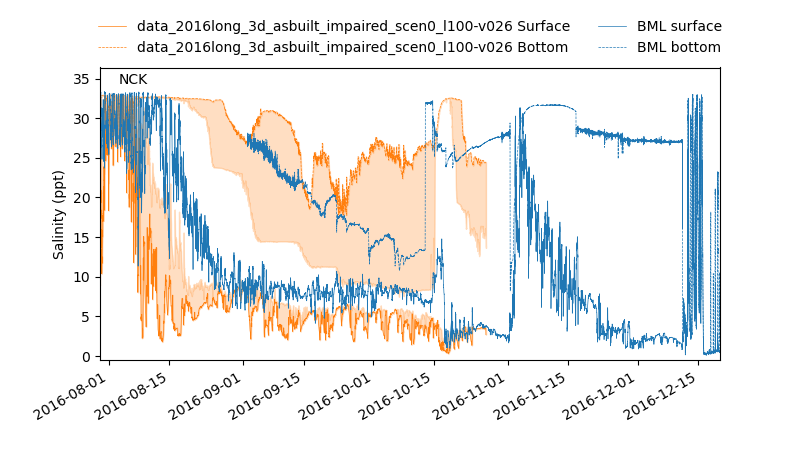

In [16]:
def surface(da):
    # assume data array is {cell or time},layer
    scal=da.values
    valid=np.isfinite(scal)
    # This gets the index of the *last* True in each column
    surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
    return np.take_along_axis(scal,surf_idxs[:,None],axis=1)[:,0]

def bottom(da):
    # assumes data array is time,layer
    scal=da.values
    valid=np.isfinite(scal)
    # index of the *first* True in each column
    bed_idxs=np.argmax(valid,axis=1)
    return np.take_along_axis(scal,bed_idxs[:,None],axis=1)[:,0] 
    
def z_from_surface(da,dz):
    # assume layer is the second of 2 dimensions
    # recover freesurface and bed.
    # Slow. Maybe from xarray wrapping?
    eta=surface(da.z_upper)
    bed=bottom(da.zcoordinate_c) 
    z_target=np.maximum(eta-dz,bed) 
    
    # Same logic as grabbing the surface cell, but instead of 
    # testing for isfinite(scal), compare z_lower<z_target
    valid=da.z_lower.values<z_target[:,None]
    tgt_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
    scal=da.values
    tgt=np.take_along_axis(scal,tgt_idxs[:,None],axis=1)[:,0]
    return tgt


def z_from_bottom(da,dz):
    # assume layer is the second of 2 dimensions
    # recover freesurface and bed.
    eta=surface(da.z_upper)
    bed=bottom(da.zcoordinate_c) 
    z_target=np.minimum(bed+dz,eta)
    valid=da.z_upper.values>=z_target[:,None]
    tgt_idxs=np.argmax(valid,axis=1)
    scal=da.values
    tgt=np.take_along_axis(scal,tgt_idxs[:,None],axis=1)[:,0]
    return tgt
    
class FigSalt:
    zoom=(16960.24667031317,
          16962.483944929114,
           -0.5475896244306924,
           36.366318197905606)
    layers=['surface','bottom'] # bed layer, and near-surface layer that is mostly wet.
    layer_styles=[dict(lw=0.5,ls='-'),
                  dict(lw=0.5,ls='--')]
    colors=['tab:blue','tab:orange','tab:green','tab:red','tab:brown','tab:purple']
    model_dz=0.25 # pull data over a range of vertical levels if > 0
    model_label=None # defaults to run directory 

    @classmethod
    def load(cls,models,station_name,layer_geometry=False):
        """
        For each run_dir, load salinity history for the named station.
        Returns a list of DataArray.
        station_name: may need to be binary.
        layer_geometry: include layer geometry to later pull intermediate levels. 
        """
        das=[]
        for model in models:
            ds=model.his_dataset()
            da=ds['salinity'].sel(stations=station_name)
            da.attrs['label']=model.run_dir
            
            if layer_geometry:
                # Need extra information to properly handle vertical range
                zcoord_w=ds['zcoordinate_w'].sel(stations=station_name)
                 
                # Appears that zcoordinate_w starts with a bed elevation,
                # ends with the surface
                # Important to rename coordinates, otherwise xarray tries to match
                # them up.
                layer_bottom=zcoord_w.isel(laydimw=slice(None,-1)).rename(laydimw='laydim',
                                                                          zcoordinate_w='z_lower')
                layer_top   =zcoord_w.isel(laydimw=slice(1,None)).rename(laydimw='laydim',
                                                                         zcoordinate_w='z_upper')
                del layer_bottom['zcoordinate_wu']
                del layer_top['zcoordinate_wu']

                da=da.assign_coords(z_lower=layer_bottom,
                                    z_upper=layer_top)

            das.append(da)
        return das
    
    def data_label(self,da):
        if self.model_label is None:
            return da.attrs['label']
        else:
            return self.model_label
        
    def __init__(self,models,his_name,bml_sfc,bml_btm,**kws):
        self.fig_dir=os.path.join(models[0].run_dir,'fig')
        utils.set_keywords(self,kws)
    
        self.das=self.load(models,his_name,layer_geometry=self.model_dz>0.0)
        self.his_name=his_name
        
        fig,ax=plt.subplots(figsize=(8,4.5))
        self.fig=fig
        self.ax=ax

        for color,stn_da in zip(self.colors[1:],self.das):
            # Pick out top/bottom finite values.
            scal=stn_da.values
            tim=stn_da.time.values
            
            da_label=self.data_label(stn_da)

            valid=np.isfinite(scal) # time,layer

            for ls,lay in zip(self.layer_styles,self.layers):
                lay_dz=None
                if lay=='surface':
                    lay_scal=surface(stn_da)
                    z_label="Surface"
                    if self.model_dz>0.0:
                        lay_dz=z_from_surface(stn_da,self.model_dz)
                elif lay=='bottom':
                    lay_scal=bottom(stn_da)
                    z_label="Bottom"
                    if self.model_dz>0.0:
                        lay_dz=z_from_bottom(stn_da,self.model_dz)
                elif isinstance(lay,(int,np.integer)):
                    # Pull a specific layer:
                    lay_scal=scal[:,lay]
                    z=stn_da.zcoordinate_c.isel(laydim=lay).mean().values
                    z_label=f"z={z:.2f} m"
                elif isinstance(lay,(float,np.float64)):
                    # Pull an elevation relative to the surface:
                    lay_scal=scal[:,lay]
                    lay_scal=z_from_surface(stn_da,lay)
                    z_label=f"z={lay:.2f} m below surface"
                # can get some mismatches when run is still going
                tim=stn_da.time.values
                N=min(len(tim),len(lay_scal))
                ax.plot(tim[:N], lay_scal[:N],
                        label=f"{da_label} {z_label}", color=color, **ls)
                if lay_dz is not None:
                    ax.fill_between(tim[:N], 
                                    lay_scal[:N],lay_dz[:N],
                                    label='__nolabel__',color=color,
                                    alpha=0.25)
            # Nan transitions:
            bad_salt=np.nonzero(np.diff(np.isnan(lay_scal[:N]))>0)[0]
            ax.plot(tim[1:N][bad_salt],
                    0*bad_salt,'kx')
                        
        # BML Data
        for ls,lay in zip(self.layer_styles,self.layers):
            if lay=='surface':
                ax.plot(bml_sfc.index.values, bml_sfc.salinity,
                        color=self.colors[0],label="BML surface",**ls)
            elif lay=='bottom':
                ax.plot(bml_btm.index.values, bml_btm.salinity, 
                        color=self.colors[0],label="BML bottom",**ls)
            else:
                print(f"No bml data for layer={lay}")

        if 0: # legend on right
            ax.legend(loc='upper left',bbox_to_anchor=[1.01,1.0])
            fig.subplots_adjust(right=0.7)
        if 1: # legend across top
            fig.subplots_adjust(top=0.85)
            ax.legend(loc='lower center',bbox_to_anchor=[0.5,1.0],
                      frameon=False,ncol=2)
        fig.autofmt_xdate()
        ax.axis( self.zoom )
        name=his_name #.decode()
        ax.text(0.03,0.98,name.upper(),transform=ax.transAxes,va='top')
        ax.set_ylabel('Salinity (ppt)')
        self.save()
    def save(self):
        if (self.fig_dir is not None) and (not os.path.exists(self.fig_dir)):
            os.makedirs(self.fig_dir)
        name=self.his_name
        if not isinstance(name,str):
            name=name.decode()
        zoom=self.ax.axis()
        t_start=num2date(zoom[0]).strftime("%m%d")
        t_stop =num2date(zoom[1]).strftime("%m%d")
        
        self.fig.savefig(os.path.join(self.fig_dir,f"salt-timeseries-{name}-{t_start}-{t_stop}.png"),
                         dpi=150)

        
        
mods=models[4:5]

#if len(mods)>1:
#    labels=utils.distinct_substrings([mod.run_dir for mod in mods])
#for mod,label in zip(mods,labels):
#    mod.attrs['label']=label

kws=dict(zoom=(17012.0, 17155, -0.5, 36.4),model_dz=0.4)
#if len(mods)==1:
#    kws['model_label']='Model'

for m in mods:
    print(m.run_dir)
# some confusion over b'nck' vs 'nck'
FigSalt(mods,'nck',bml_nck_sfc_mcat,bml_nck_btm_mcat,**kws)

<IPython.core.display.Javascript object>


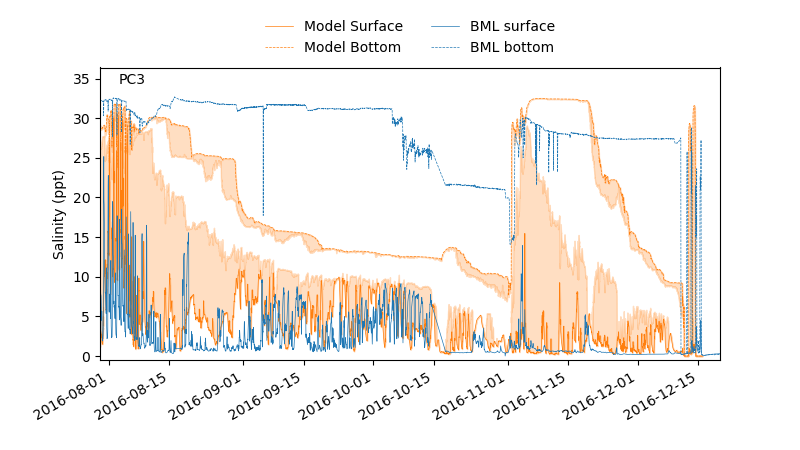

<IPython.core.display.Javascript object>


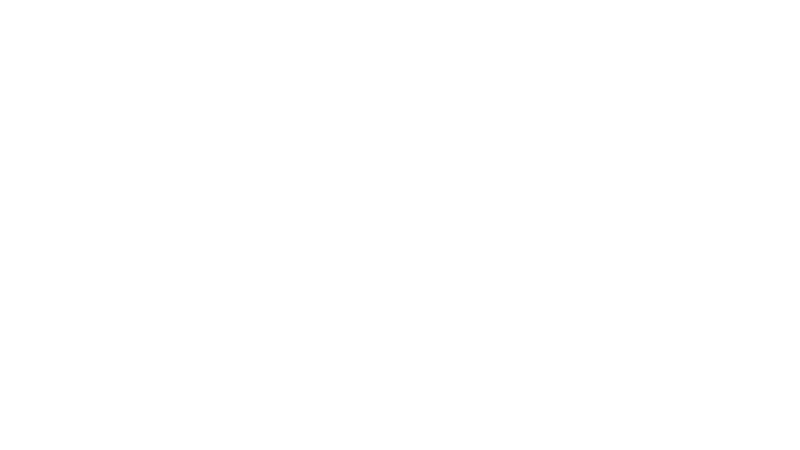

<IPython.core.display.Javascript object>


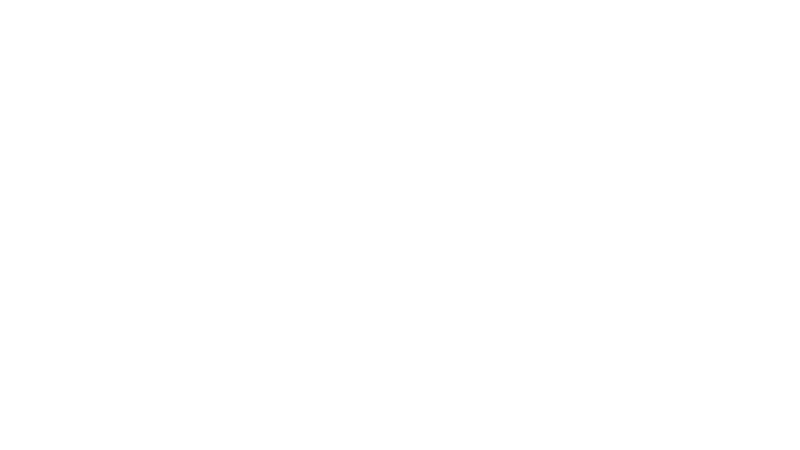

<IPython.core.display.Javascript object>


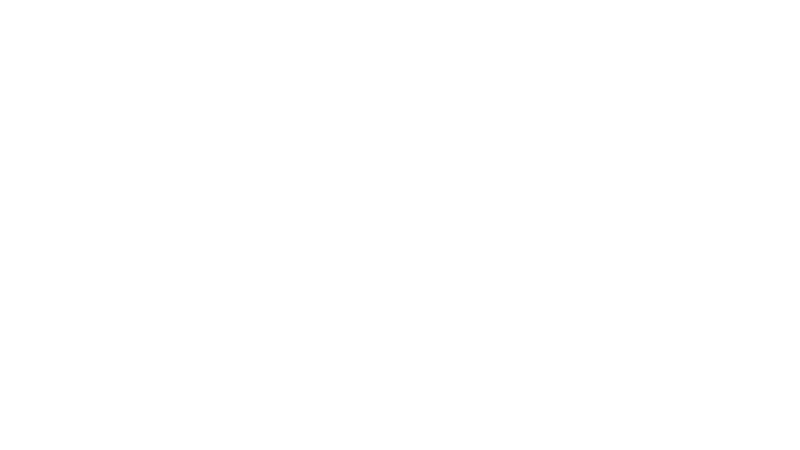

In [12]:
FigSalt(mods,'pc3',bml_pc3_sfc_sond,bml_pc3_btm_sond,**kws)

FigSalt(mods,'bc1',bml_bc1_sfc_sond,bml_bc1_btm_sond,**kws)

FigSalt(mods,'BC3',bml_bc3_sfc_mcat,bml_bc3_btm_mcat,**kws)

FigSalt(mods,'ch2',bml_ch2_sfc_mcat,bml_ch2_btm_mcat,**kws)

In [81]:
print(f"Start {models[0].run_start}")
print(f"Stop  {models[0].run_stop}")
print(f"Days  {(models[0].run_stop - models[0].run_start)/np.timedelta64(86400,'s')}")

Start 2016-07-15T00:00:00.000000
Stop  2016-12-16T00:00:00.000000
Days  154.0


In [11]:
six.moves.reload_module(multi_ugrid)
mu=multi_ugrid.MultiUgrid(f"{models[0].run_dir}/DFM_OUTPUT_flowfm/*_map.nc",
                         cleanup_dfm=True)

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Removing orphaned nodes
INFO:UnstructuredGrid:0 nodes found to be orphans
INFO:UnstructuredGrid:Removing duplicate nodes
INFO:UnstructuredGrid:Renumbering nodes
INFO:UnstructuredGrid:Renumbering edges
INFO:UnstructuredGrid:Extracting grid boundary
INFO:UnstructuredGrid:Regenerating edges
INFO:UnstructuredGrid:Remo

In [602]:
t_start_s=(np.datetime64("2016-06-22T00:00") - mu.time.values[0]) / np.timedelta64(1,'s')
t_start_s, t_start_s+86400*2

(1036800.0, 1209600.0)

In [626]:
fig_dir="figs-20210611"
if not os.path.exists(fig_dir):
    os.makedirs(fig_dir)

<IPython.core.display.Javascript object>


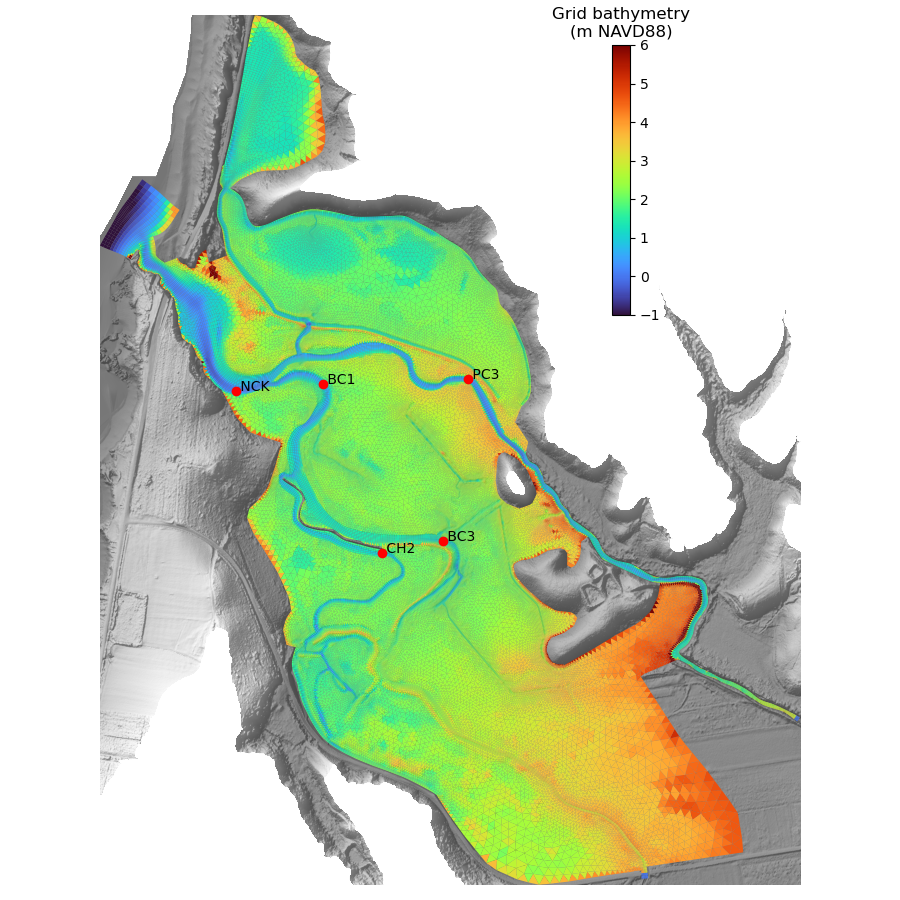

In [627]:
# Make a nice grid/bathy/station figure
from stompy.spatial import field
fig,ax=plt.subplots(1,1,figsize=(9,9))

#zoom=(551932.9888888889, 553361.1838709676, 4123382.36344086, 4125404.205734767)
zoom=mu.grid.bounds()

dem=field.GdalGrid("../../bathy/compiled-dem-existing-20210608-1m.tif")

dem.crop(zoom).plot(ax=ax,cmap='gray',alpha=0.5)
# could put the hillshade above the grid, but it's misleading
dem.crop(zoom).plot_hillshade(ax=ax,plot_args=dict(alpha=0.5))
ccoll=mu.grid.plot_cells(values=mu['mesh2d_flowelem_bl'].values,cmap='turbo',ax=ax,
                         clim=[-1,6])

for stn in ['nck','pc3','bc1','BC3','ch2']:
    stn_idx=list(his_ds.station_name.values).index(stn.encode())
    stn_ds=his_ds.isel(stations=stn_idx)
    x=stn_ds.station_x_coordinate
    y=stn_ds.station_y_coordinate
    
    ax.text(x,y," "+stn.upper())
    ax.plot([x],[y],'ro')
    
ax.axis('off')
fig.tight_layout()

cax=fig.add_axes([0.68,0.65,0.02,0.30])
plt.colorbar(ccoll,cax=cax)
cax.set_title('Grid bathymetry\n(m NAVD88)')

fig.savefig(fig_dir+"/grid-stations-bathy.png",dpi=150)

In [624]:
ccoll.set_clim([-1,6])

<IPython.core.display.Javascript object>


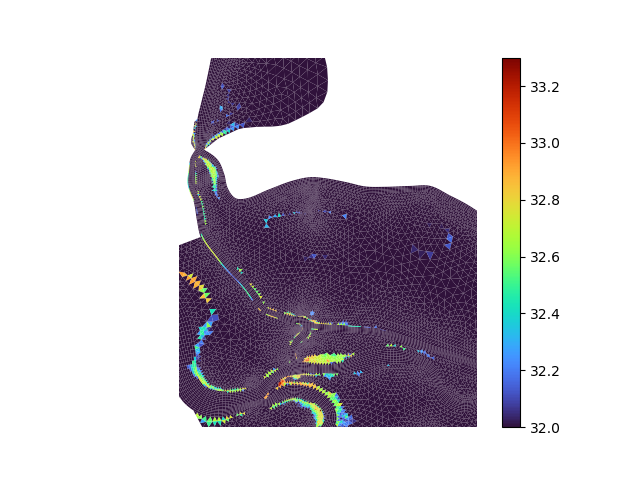

Max salinity:  33.36614018210324


In [56]:
snap=mu.isel(time=-1)
zoom=mu.grid.bounds()

def surface(da):
    # assume data array is {cell or time},layer
    scal=da.values
    valid=np.isfinite(scal)
    surf_idxs=valid.shape[1]-1-np.argmax(valid[:,::-1],axis=1)
    return np.take_along_axis(scal,surf_idxs[:,None],axis=1)[:,0]

fig,ax=plt.subplots()
# Find a nice salinity snapshot for a restart to make an animation
ccoll=mu.grid.plot_cells(values=surface(snap['mesh2d_sa1']),
                   #mask=snap['mesh2d_waterdepth'].values>0.01,
                   cmap='turbo',clim=[32,33.3],ax=ax)
plt.colorbar(ccoll)
ax.axis(zoom)
ax.axis('off')
print("Max salinity: ",np.nanmax(surface(snap['mesh2d_sa1'])))

In [55]:
mu.time

<xarray.DataArray 'time' (time: 3)>
array(['2016-07-15T00:00:00.000000000', '2016-07-17T00:00:00.000000000',
       '2016-07-19T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2016-07-15 2016-07-17 2016-07-19
Attributes:
    standard_name:  time

Time steps
---

In [13]:
list(mu.dss[0])


['projected_coordinate_system',
 'mesh2d',
 'mesh2d_node_z',
 'mesh2d_edge_nodes',
 'mesh2d_face_nodes',
 'mesh2d_edge_faces',
 'mesh2d_face_x_bnd',
 'mesh2d_face_y_bnd',
 'mesh2d_interface_z',
 'mesh2d_edge_type',
 'mesh2d_flowelem_ba',
 'mesh2d_flowelem_bl',
 'mesh2d_flowelem_domain',
 'mesh2d_flowelem_globalnr',
 'timestep',
 'mesh2d_Numlimdt',
 'mesh2d_waterdepth',
 'mesh2d_s1',
 'mesh2d_ucmag',
 'mesh2d_ucmaga',
 'mesh2d_taus',
 'mesh2d_sa1',
 'mesh2d_tem1']

<IPython.core.display.Javascript object>


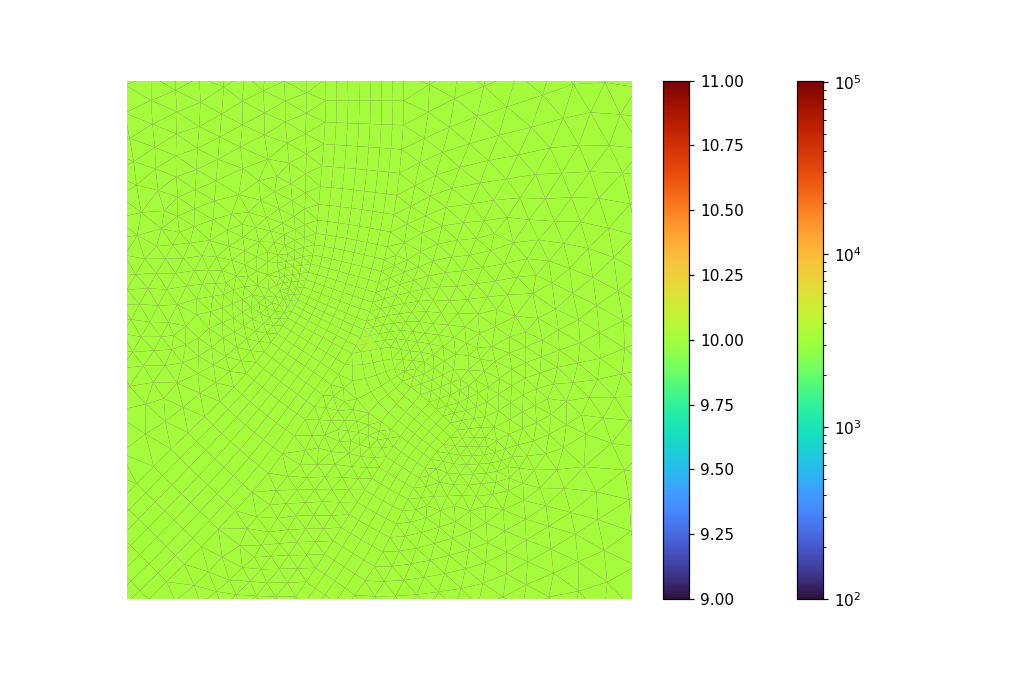

In [19]:
from matplotlib import colors
fig,ax=plt.subplots()
ax.set_adjustable('datalim')
ccoll=mu.grid.plot_cells(values=mu['mesh2d_Numlimdt'].isel(time=-1).values.clip(10),
                   norm=colors.LogNorm(vmin=100,clip=True),cmap='turbo')
ax.axis('off')
plt.colorbar(ccoll)

<IPython.core.display.Javascript object>


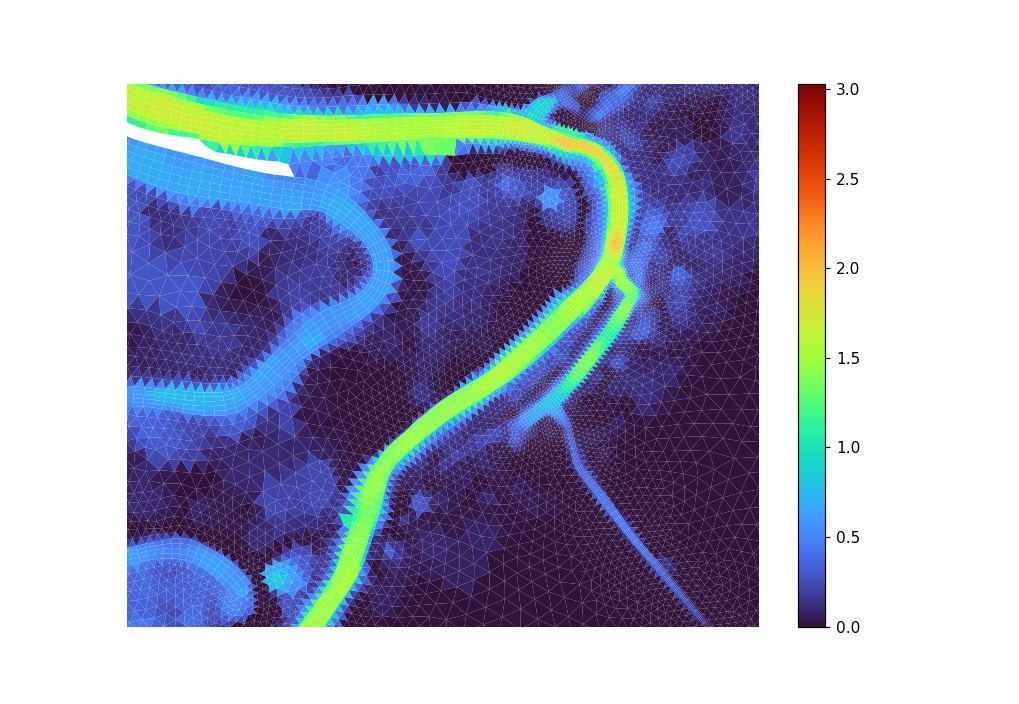

In [22]:
fig,ax=plt.subplots()
ax.set_adjustable('datalim')
ccoll=mu.grid.plot_cells(values=mu['mesh2d_waterdepth'].isel(time=-1).values,
                         cmap='turbo')
ax.axis('off')
plt.colorbar(ccoll)

In [11]:
# Is there a noticeable difference in eddy diffusivity?
mod=models[0]
his_ds=mod.his_dataset()

In [14]:
his_ds.cross_section

<xarray.DataArray 'cross_section' (cross_section: 10)>
array(['mouth_xs', 'n_pond_xs', 'n_ditch_xs', 'n_complex_xs', 'pesca_mid_xs',
       'butano_lower_xs', 'pesca_lower_xs', 'pesca_bc_xs', 'butano_bc_xs',
       'butano_mid_xs'], dtype='<U15')
Coordinates:
    cross_section_name  (cross_section) |S64 b'mouth_xs' ... b'butano_mid_xs'
  * cross_section       (cross_section) <U15 'mouth_xs' ... 'butano_mid_xs'

In [ ]:
xs=his_ds.sel(cross_section='pesca_mid_xs')
xs.cross_section_salt

In [2]:
his_ds

NameError: name 'his_ds' is not defined